# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/My Drive/Prak_MLMI')

Mounted at /content/drive


In [3]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data and Model

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [4]:
prak_dir = '/content/drive/My Drive/Prak_MLMI'
imagenet_dir = '/content/drive/My Drive/Prak_MLMI/imagenet'

dev = torch.device('cuda:0')

# select a model to analyse
# model = torchvision.models.vgg16(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
valset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open(os.path.join(prak_dir, 'imagenet_class_index.json')) as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
img, target = valset[0]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [5]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [6]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [7]:
iba.estimate(model, trainloader, device=dev, n_samples=5000, progbar=True)

In [8]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean 0.11 and std 0.13


In [9]:
iba.estimator.n_samples()

5056

## Display Heatmaps for some random samples



In [ ]:
%matplotlib inline

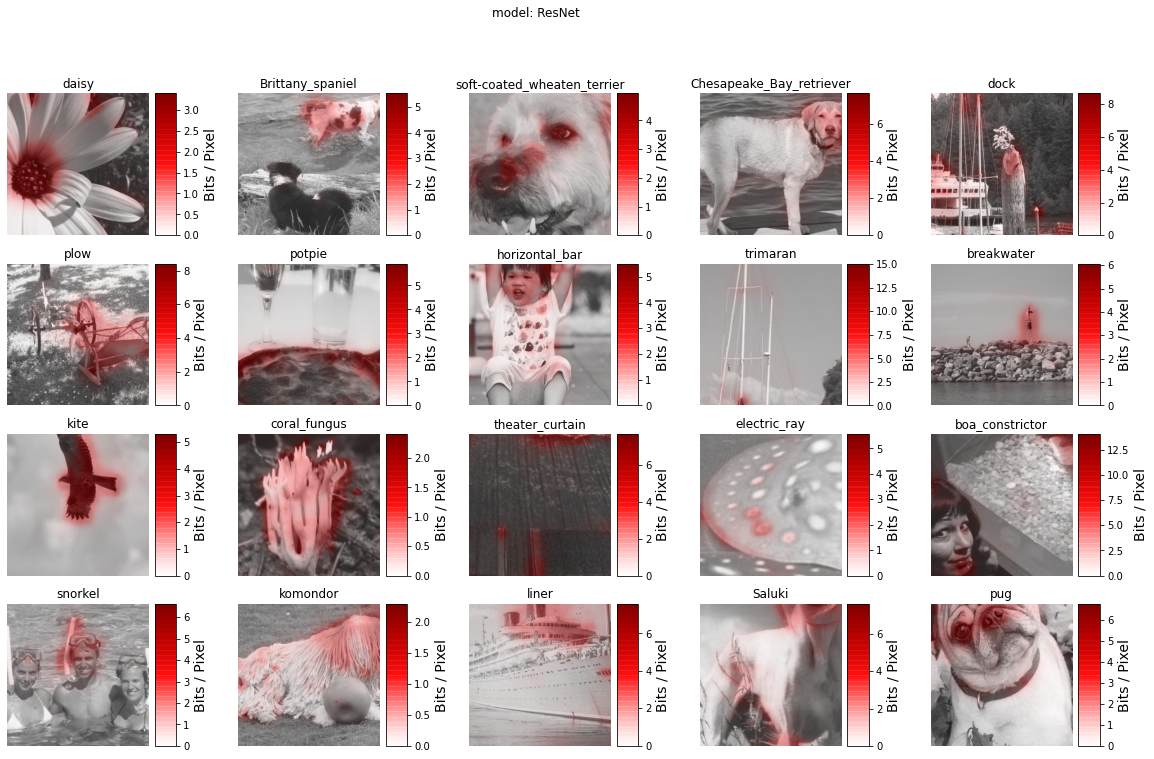

In [17]:
seed = np.random.randint(0, 1000000000)
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
np.random.seed(seed)
iba.reverse_lambda = False
iba.beta = 10
for ax, sample_idx in zip(axes.flatten(), np.random.choice(10000, 20)):
    img, target = trainset[sample_idx]
    img = img[None].to(dev)
    
    # execute the model on a given sample and return the target NLL
    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    
    # generate the heatmap
    heatmap = iba.analyze(img, model_loss_closure)
    
    # reverse the data pre-processing for plotting the original image
    np_img = tensor_to_np_img(img[0])
    
    # show the heatmap
    plot_saliency_map(heatmap, np_img,  ax=ax)
    ax.set_title(idx2class[target])
    
fig.suptitle("model: {}".format(type(model).__name__))
plt.show()

use inversed mask


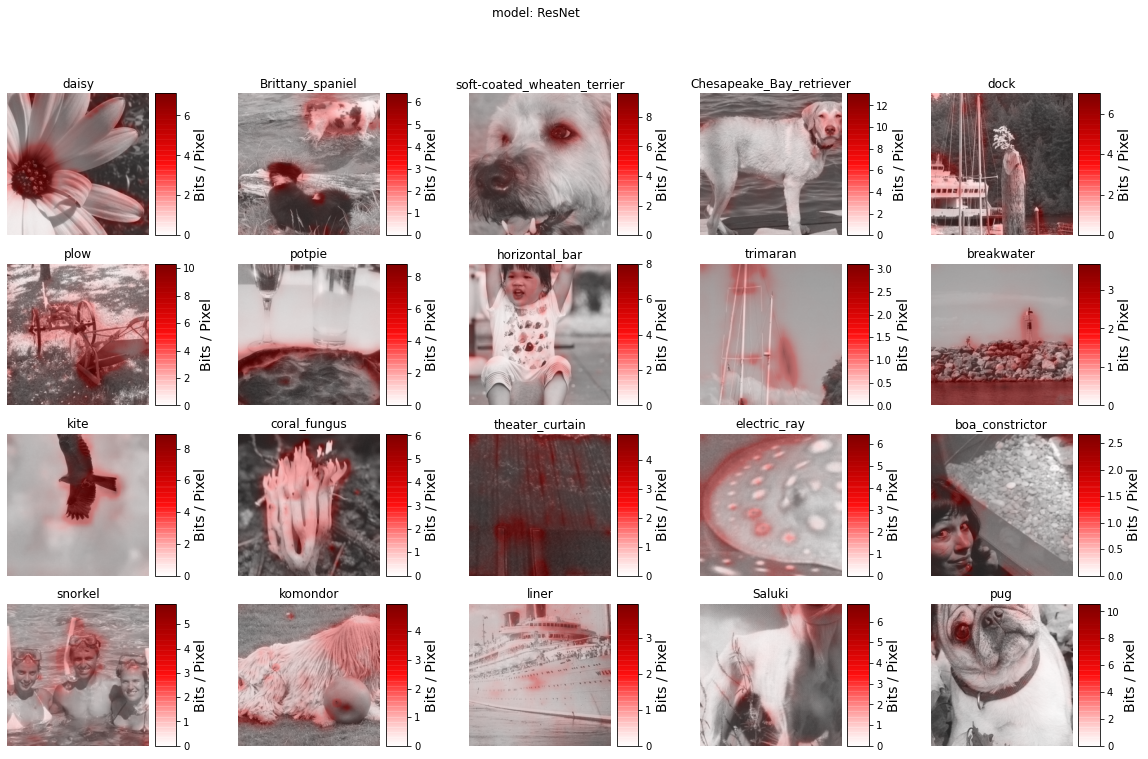

In [18]:
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
np.random.seed(seed)
iba.reverse_lambda = True
iba.beta = 30
print("use inversed mask")
for ax, sample_idx in zip(axes.flatten(), np.random.choice(10000, 20)):
    img, target = trainset[sample_idx]
    img = img[None].to(dev)
    
    # execute the model on a given sample and return the target NLL
    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    
    # generate the heatmap
    heatmap = iba.analyze(img, model_loss_closure)
    
    # reverse the data pre-processing for plotting the original image
    np_img = tensor_to_np_img(img[0])
    
    # show the heatmap
    plot_saliency_map(heatmap, np_img,  ax=ax)
    ax.set_title(idx2class[target])
    
fig.suptitle("model: {}".format(type(model).__name__))
plt.show()

## Monkey image

Old method


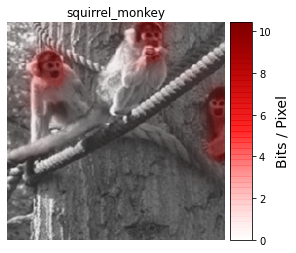

New method


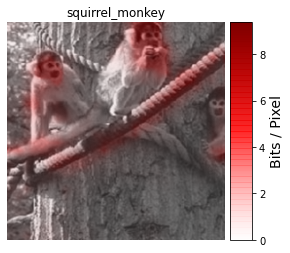

In [ ]:
# img = np.array(Image.open(os.path.join(prak_dir, "monkeys.jpg")))
# img = (img.transpose(2, 0, 1) / 255)
target = 382  # 382: squirrel monkey

# preprocess image
img  = Compose([
    Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "monkeys.jpg")))

print("Old method")
iba.reverse_lambda = False
iba.beta = 10
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

print("New method")
iba.reverse_lambda = True
iba.beta = 30
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

In [ ]:
print("Predict confidence without mask: {}".format(torch.softmax(model(img[None].to(dev)), 1)[:, 382].item()))
with iba.restrict_flow():
  print("Predict confidence without mask: {}".format(torch.softmax(model(img[None].to(dev)), 1)[:, 382].item()))

print("Confidence history:".format(torch.exp(-torch.tensor(iba._model_loss))))

Predict confidence without mask: 0.8342097401618958
Predict confidence without mask: 0.7426466941833496


## Comparison between methods for images with multiple target objects

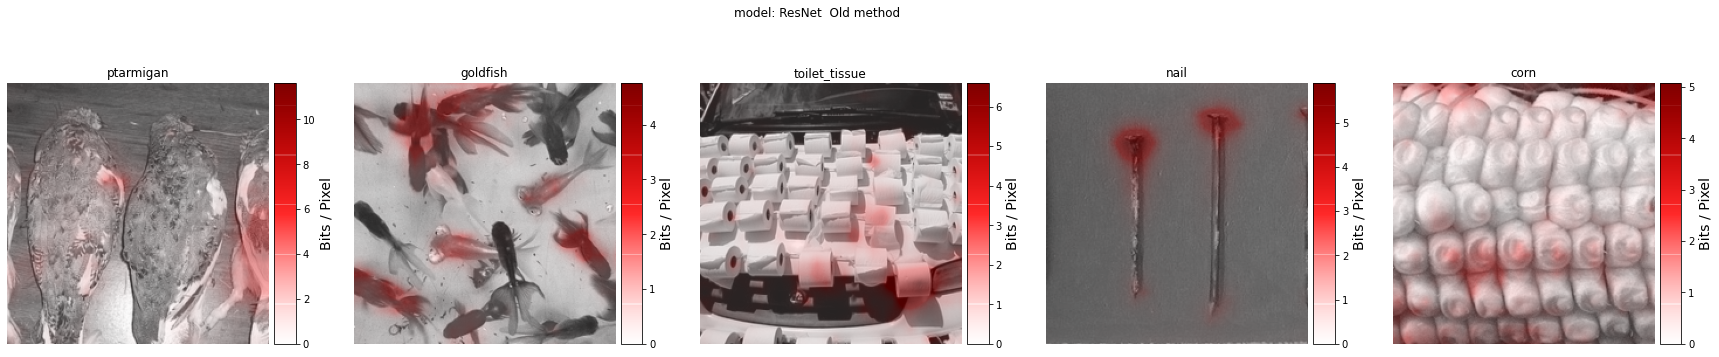

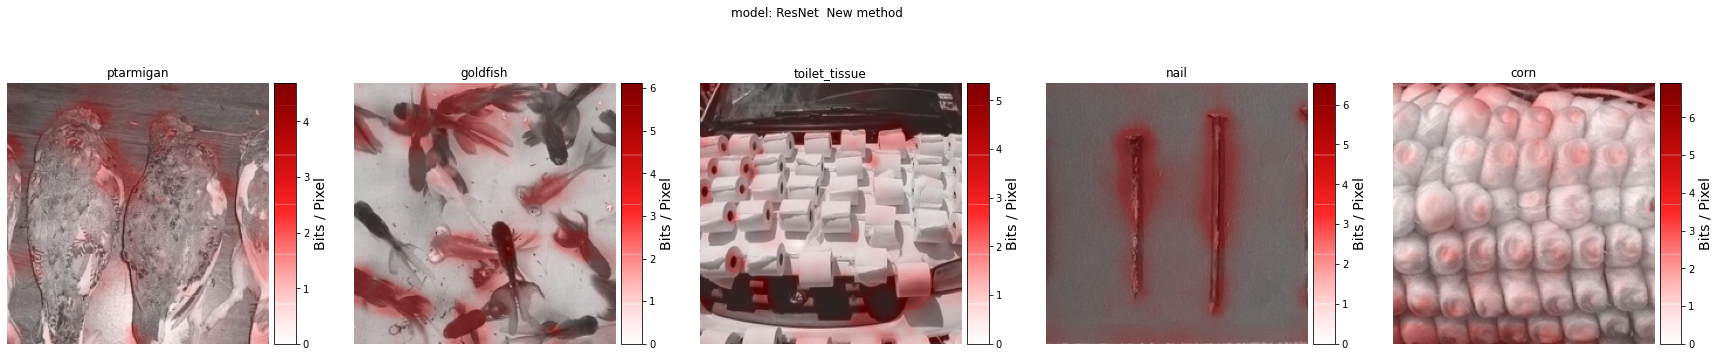

In [16]:
imgs = []
img  = Compose([
    CenterCrop(256), Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "ptarmigan.jpg")))
imgs.append(img)
img  = Compose([
    CenterCrop(256), Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "gold_fish_1.jpg")))
imgs.append(img)
img  = Compose([
    CenterCrop(256), Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "toilet_tissue.jpg")))
imgs.append(img)
img  = Compose([
    CenterCrop(256), Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "nail.jpg")))
imgs.append(img)
img  = Compose([
    CenterCrop(256), Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(prak_dir, "corn.jpg")))
imgs.append(img)

targets = [81, 1, 999, 677, 987]

# plot old method
lentgh = len(targets)
fig, axes = plt.subplots(1, lentgh, figsize=(30, 6))
for ax, sample_idx in zip(axes.flatten(), range(lentgh)):
  img = imgs[sample_idx]
  target = targets[sample_idx]
  iba.reverse_lambda = False
  iba.beta = 10
  model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
  heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
  plot_saliency_map(heatmap, tensor_to_np_img(img),  ax=ax)
  _ = ax.set_title(idx2class[target])
fig.suptitle("model: {}".format(type(model).__name__) + "  Old method")
plt.show()

# plot new method
fig, axes = plt.subplots(1, lentgh, figsize=(30, 6))
for ax, sample_idx in zip(axes.flatten(), range(lentgh)):
  img = imgs[sample_idx]
  target = targets[sample_idx]
  iba.reverse_lambda = True
  iba.beta = 30
  model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
  heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
  plot_saliency_map(heatmap, tensor_to_np_img(img),  ax=ax)
  _ = ax.set_title(idx2class[target])
    
fig.suptitle("model: {}".format(type(model).__name__) + "  New method")
plt.show()

##   Drawback of new method
Items similar to the target may also be included in the attribution map, because for this part the network assigns noteable score (>>0%)

Old method


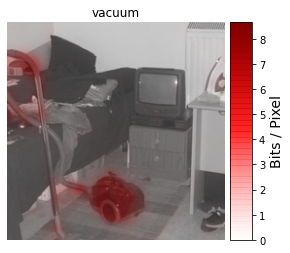

New method


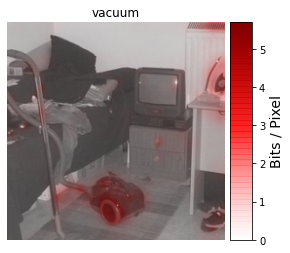

In [22]:
target = 882  # 1:  gold fish

# preprocess image
img  = Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(Image.open(os.path.join(prak_dir, "iron.jpg")))

print("Old method")
iba.reverse_lambda = False
iba.beta = 10
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

print("New method")
iba.reverse_lambda = True
iba.beta = 30
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()